# Orginial best performing feature subset with ridge regression 

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from copy import copy
import scipy
import pickle

# %% Configuration
# Configuration parameters
droprows = 7050
std_reg_const = 0.1
normalization_std_reg = 0.0001
ridge_alpha = 1333

selected_cols = [
    # Opening/Closing difference features
    'xdiff_from_opening',
    
    # X-price features
    'xlog',
    'xlog_dayly_ewma_10min',
    'xprice_dayly_ewma_4hour',
    'xprice_lag_4hours',
    'xprice_time_mean_1hour_lag_4hours',
    'xprice_time_mean_10min_dayly_ewma_10min',
    
    # Y-price features
    'ylog_dayly_ewma_1hour',
    'yprice_dayly_ewma_10min',
    'yprice_ewma_difpair_10min_4hour',
    'yprice_expanding_mean_diff',  # FIXED: renamed from yprice_full_history_diff
    'yprice_time_mean_1hour',
    'yprice_time_mean_1hour_lag_1workweek',
    'yprice_time_mean_10min',
    'yprice_time_mean_10min_dayly_ewma_4hour',
    'yprice_time_mean_10min_lag_10min',
    'yprice_time_mean_10min_rsi_1hour',
    'yprice_time_mean_2hours',
    'yprice_time_zscore_1hour',
    'yprice_time_zscore_2hours',
    
    # XY combined features
    'xy_garmonic_time_std_4hours',
    'xy_geom_time_mean_2hours_dayly_ewma_20min',
    'xy_square_time_zscore_10min',
    
    # YX spread features
    'yx_spread_ewma_prodpair_1hour_10min',
    'yx_spread_time_mean_10min_lag_1hour',
    'yx_spread_time_zscore_4hours',
]


# %% Helper Functions
def print_importances(model, selected_cols):
    """Print feature importances sorted by absolute weight"""
    weigts_sum = sum(map(abs, model.coef_))
    for name, weight in sorted(zip(selected_cols, model.coef_), key=lambda x: -abs(x[1])):
        percent_weight = abs(weight) / weigts_sum
        print('{:40} {:.2%} {:15.2}'.format(name, percent_weight, weight))

def rsquared(x, y):
    """Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def rsiFunc(prices, n=14):
    """Calculate RSI (Relative Strength Index)"""
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1]
        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)
    return rsi

# %% Time Series Validation Functions
def time_split(data, valid_ratio, test_ratio):
    """Split time series data into train, validation, and test sets"""
    n_valid = max(1, int(data.shape[0] * valid_ratio))
    n_test = max(1, int(data.shape[0] * test_ratio))
    n_train = data.shape[0] - n_valid - n_test
    
    train = data.iloc[:n_train].reset_index(drop=True).copy()
    valid = data.iloc[n_train:-n_test].reset_index(drop=True).copy()
    test = data.iloc[-n_test:].reset_index(drop=True).copy()
    merged_test = pd.concat([valid, test], ignore_index=True)
    return train, valid, test

def validate_model_by_pentate(model, source_data, base_cols, droprows=0):
    """Validate model using 5-fold time series cross-validation"""
    df = source_data.copy()
    selected_cols = base_cols.copy()
    helper_cols = list(set(selected_cols + ['periods_before_closing', 'returns']))
    metrics_dict = {}
    
    for step in range(5, 10):
        n_train = int(df.shape[0] * step // 10)
        n_test = int(df.shape[0] * (step + 1) // 10)
        train = df.iloc[:n_train].reset_index(drop=True).copy()
        test = df.iloc[n_train:n_test].reset_index(drop=True).copy()
        train.drop(np.arange(droprows), inplace=True)
        train.dropna(inplace=True)

        model.fit(train[selected_cols], train.returns)
        predicted = model.predict(test[selected_cols])
        predicted[test.periods_before_closing == 0] = 0

        current_mse = mean_squared_error(test.returns, predicted)
        current_r2 = rsquared(test.returns, predicted) * 100
        metrics_dict['train_{}_percent'.format(step * 10)] = {
            'mse': current_mse,
            'r2': current_r2
        }
    
    report = pd.DataFrame(metrics_dict)
    report['min_stats'] = report.iloc[:,:5].min(1).astype(np.float32)
    report['max_stats'] = report.iloc[:,:5].max(1).astype(np.float32)
    report['avg'] = report.mean(1).astype(np.float32)
    return report

# %% FIXED Feature Engineering Function
def create_all_features(data):
    """
    FIXED: Feature engineering without data leakage.
    All features only use data available up to time t to predict returns at time t.
    """
    print("Creating all features (FIXED - no data leakage)...")
    
    # Pre-calculate commonly used values
    days = data.day.unique()
    
    # Opening/Closing differences
    print("Creating opening/closing difference features...")
    close_price_per_day_y = data.groupby('day').timestamp.max().shift(1).map(
        data[['timestamp', 'yprice']].set_index('timestamp').yprice)
    data['ydiff_from_closing'] = (data.yprice - data.day.map(close_price_per_day_y)).fillna(0)
    
    close_price_per_day_x = data.groupby('day').timestamp.max().shift(1).map(
        data[['timestamp', 'xprice']].set_index('timestamp').xprice)
    data['xdiff_from_closing'] = (data.xprice - data.day.map(close_price_per_day_x)).fillna(0)
    
    open_price_per_day_x = data.groupby('day').timestamp.min().map(
        data[['timestamp', 'xprice']].set_index('timestamp').xprice)
    data['xdiff_from_opening'] = data.xprice - data.day.map(open_price_per_day_x)
    
    # Log features
    print("Creating log features...")
    data['xlog'] = data.xprice.apply(np.log1p)
    data['ylog'] = data.yprice.apply(np.log1p)
    
    # FIXED: Expanding mean that only uses past data
    print("Creating expanding mean difference (FIXED)...")
    data['yprice_expanding_mean_diff'] = data['yprice'] - data['yprice'].expanding(min_periods=1).mean()
    
    # FIXED: Time-based rolling features with backward-looking windows
    print("Creating time-based rolling features (FIXED)...")
    time_windows = {
        6: '1min', 60: '10min', 360: '1hour', 720: '2hours', 1410: '4hours', 2820: '1workweek'
    }
    
    # FIXED: Create all rolling means with backward-looking windows
    for window, name in time_windows.items():
        if window in [6, 60, 360, 1410]:  # xprice windows
            period_repr = '{}s'.format(window * 10)
            # FIXED: Use label='left' and closed='left' for backward-looking windows
            agg_helper_df = data['xprice'].resample(
                period_repr, label='left', closed='left').agg('mean')
            # Aggregate with multiple offsets to get more granular averages
            for shift in range(10, window * 10, 10):
                shifted_df = data['xprice'].resample(
                    period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
                agg_helper_df = pd.concat([agg_helper_df, shifted_df])
            colname = f'xprice_time_mean_{name}'
            # Forward fill to propagate past values forward
            agg_helper_df = agg_helper_df.sort_index()
            data[colname] = agg_helper_df.reindex(data.index).ffill()
            data[colname] = data['xprice'] - data[colname]
        
        if window in [60, 360, 720]:  # yprice windows
            period_repr = '{}s'.format(window * 10)
            # FIXED: Use label='left' and closed='left' for backward-looking windows
            agg_helper_df = data['yprice'].resample(
                period_repr, label='left', closed='left').agg('mean')
            for shift in range(10, window * 10, 10):
                shifted_df = data['yprice'].resample(
                    period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
                agg_helper_df = pd.concat([agg_helper_df, shifted_df])
            colname = f'yprice_time_mean_{name}'
            agg_helper_df = agg_helper_df.sort_index()
            data[colname] = agg_helper_df.reindex(data.index).ffill()
            data[colname] = data['yprice'] - data[colname]
    
    # FIXED: Create rolling std for yprice with backward-looking windows
    for window in [360, 720]:
        name = time_windows[window]
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['yprice'].resample(
            period_repr, label='left', closed='left').agg('std')
        for shift in range(10, window * 10, 10):
            shifted_df = data['yprice'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('std')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'yprice_time_std_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    
    # Z-scores for yprice
    data['yprice_time_zscore_1hour'] = data.yprice_time_mean_1hour / data.yprice_time_std_1hour
    data['yprice_time_zscore_2hours'] = data.yprice_time_mean_2hours / data.yprice_time_std_2hours
    
    # Intraday EWMA features (backward-looking by nature)
    print("Creating intraday EWMA features...")
    ewma_configs = [
        ('xprice', [24], ['4hour']),
        ('xlog', [60], ['10min']),
        ('ylog', [360], ['1hour']),
        ('yprice', [24, 60], ['4hour', '10min'])
    ]
    
    for col, windows, names in ewma_configs:
        for day in days:
            df_mask = (data.day == day)
            for window, name in zip(windows, names):
                colname = f'{col}_dayly_ewma_{name}'
                # EWMA is backward-looking by default
                ewm = pd.Series.ewm(data.loc[df_mask, col], halflife=window).mean().values
                data.loc[df_mask, colname] = ewm
                if col in ['xprice', 'yprice']:
                    data.loc[df_mask, colname] = data.loc[df_mask, col] - data.loc[df_mask, colname]
                elif col in ['xlog', 'ylog']:
                    data.loc[df_mask, colname] = data.loc[df_mask, col.replace('log', 'price')] - data.loc[df_mask, colname]
    
    # EWMA difference pair
    data['yprice_ewma_difpair_10min_4hour'] = data.yprice_dayly_ewma_10min - data.yprice_dayly_ewma_4hour
    
    # Lag features (inherently backward-looking)
    print("Creating lag features...")
    lag_configs = [
        ('xprice', 1410, '4hours'),
        ('yprice', 1410, '4hours'),
        ('xprice_time_mean_1hour', 1410, '4hours'),
        ('yprice_time_mean_1hour', 1410, '4hours'),
        ('yprice_time_mean_1hour', 2820, '1workweek'),
        ('yprice_time_mean_10min', 60, '10min')
    ]
    
    for col, lag, name in lag_configs:
        data[f'{col}_lag_{name}'] = data[col].shift(lag).values
    
    # RSI features (calculated sequentially, backward-looking)
    print("Creating RSI features...")
    data['xprice_time_mean_1min_rsi_1min'] = rsiFunc(data['xprice_time_mean_1min'].values, 6)
    data['yprice_time_mean_10min_rsi_1hour'] = rsiFunc(data['yprice_time_mean_10min'].values, 360)
    
    # Additional EWMA on time means
    print("Creating EWMA on time means...")
    ewma_on_means = [
        ('xprice_time_mean_10min', 60, '10min'),
        ('yprice_time_mean_10min', 24, '4hour')
    ]
    
    for col, window, name in ewma_on_means:
        for day in days:
            df_mask = (data.day == day)
            colname = f'{col}_dayly_ewma_{name}'
            ewm = pd.Series.ewm(data.loc[df_mask, col], halflife=window).mean().values
            data.loc[df_mask, colname] = ewm
    
    # FIXED: XY Combined features with backward-looking windows
    print("Creating XY combined features (FIXED)...")
    
    # XY Harmonic std
    agg_helper_df = data['xy_garmonic'].resample(
        '14100s', label='left', closed='left').agg('std')
    for shift in range(10, 14100, 10):
        shifted_df = data['xy_garmonic'].resample(
            '14100s', label='left', closed='left', offset='{}s'.format(shift)).agg('std')
        agg_helper_df = pd.concat([agg_helper_df, shifted_df])
    agg_helper_df = agg_helper_df.sort_index()
    data['xy_garmonic_time_std_4hours'] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    
    # Harmonic EWMA
    for day in days:
        df_mask = (data.day == day)
        data.loc[df_mask, 'xy_garmonic_dayly_ewma_1hour'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_garmonic'], halflife=360).mean().values
        data.loc[df_mask, 'xy_garmonic_dayly_ewma_2hours'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_garmonic'], halflife=720).mean().values
    
    data['xy_garmonic_dayly_ewma_1hour'] = data['xy_garmonic'] - data['xy_garmonic_dayly_ewma_1hour']
    data['xy_garmonic_dayly_ewma_2hours'] = data['xy_garmonic'] - data['xy_garmonic_dayly_ewma_2hours']
    data['xy_garmonic_ewma_prodpair_2hours_1hour'] = (
        data.xy_garmonic_dayly_ewma_2hours * data.xy_garmonic_dayly_ewma_1hour)
    
    # FIXED: XY Geometric features with backward-looking windows
    for window, name in [(6, '1min'), (60, '10min'), (360, '1hour'), (720, '2hours')]:
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['xy_geom'].resample(
            period_repr, label='left', closed='left').agg('mean')
        for shift in range(10, window * 10, 10):
            shifted_df = data['xy_geom'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'xy_geom_time_mean_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill()
        data[colname] = data['xy_geom'] - data[colname]
    
    # Geometric lags and EWMA
    data['xy_geom_time_mean_1hour_lag_20min'] = data['xy_geom_time_mean_1hour'].shift(120).values
    
    for day in days:
        df_mask = (data.day == day)
        data.loc[df_mask, 'xy_geom_time_mean_10min_dayly_ewma_1min'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_geom_time_mean_10min'], halflife=6).mean().values
        data.loc[df_mask, 'xy_geom_time_mean_2hours_dayly_ewma_20min'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_geom_time_mean_2hours'], halflife=120).mean().values
    
    # FIXED: XY Relation std with backward-looking windows
    for window, name in [(360, '1hour'), (720, '2hours')]:
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['xy_relation'].resample(
            period_repr, label='left', closed='left').agg('std')
        for shift in range(10, window * 10, 10):
            shifted_df = data['xy_relation'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('std')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'xy_relation_time_std_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    
    # FIXED: XY Square zscore with backward-looking windows
    agg_helper_df_mean = data['xy_square'].resample(
        '600s', label='left', closed='left').agg('mean')
    agg_helper_df_std = data['xy_square'].resample(
        '600s', label='left', closed='left').agg('std')
    
    for shift in range(10, 600, 10):
        shifted_mean = data['xy_square'].resample(
            '600s', label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
        shifted_std = data['xy_square'].resample(
            '600s', label='left', closed='left', offset='{}s'.format(shift)).agg('std')
        agg_helper_df_mean = pd.concat([agg_helper_df_mean, shifted_mean])
        agg_helper_df_std = pd.concat([agg_helper_df_std, shifted_std])
    
    agg_helper_df_mean = agg_helper_df_mean.sort_index()
    agg_helper_df_std = agg_helper_df_std.sort_index()
    data['xy_square_time_mean_10min'] = data['xy_square'] - agg_helper_df_mean.reindex(data.index).ffill()
    data['xy_square_time_std_10min'] = agg_helper_df_std.reindex(data.index).ffill().fillna(0) + std_reg_const
    data['xy_square_time_zscore_10min'] = data['xy_square_time_mean_10min'] / data['xy_square_time_std_10min']
    
    # FIXED: YX Spread features with backward-looking windows
    print("Creating YX spread features (FIXED)...")
    for window, name in [(60, '10min'), (720, '2hours'), (1410, '4hours')]:
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['yx_spread'].resample(
            period_repr, label='left', closed='left').agg('mean')
        for shift in range(10, window * 10, 10):
            shifted_df = data['yx_spread'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'yx_spread_time_mean_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill()
        data[colname] = data['yx_spread'] - data[colname]
    
    # FIXED: Spread std and zscore with backward-looking windows
    agg_helper_df = data['yx_spread'].resample(
        '14100s', label='left', closed='left').agg('std')
    for shift in range(10, 14100, 10):
        shifted_df = data['yx_spread'].resample(
            '14100s', label='left', closed='left', offset='{}s'.format(shift)).agg('std')
        agg_helper_df = pd.concat([agg_helper_df, shifted_df])
    agg_helper_df = agg_helper_df.sort_index()
    data['yx_spread_time_std_4hours'] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    data['yx_spread_time_zscore_4hours'] = data['yx_spread_time_mean_4hours'] / data['yx_spread_time_std_4hours']
    
    # Spread lags (inherently backward-looking)
    data['yx_spread_time_mean_10min_lag_1hour'] = data['yx_spread_time_mean_10min'].shift(360).values
    data['yx_spread_time_mean_2hours_lag_20min'] = data['yx_spread_time_mean_2hours'].shift(120).values
    
    # Spread EWMA (backward-looking by nature)
    for day in days:
        df_mask = (data.day == day)
        data.loc[df_mask, 'yx_spread_dayly_ewma_10min'] = pd.Series.ewm(
            data.loc[df_mask, 'yx_spread'], halflife=60).mean().values
        data.loc[df_mask, 'yx_spread_dayly_ewma_1hour'] = pd.Series.ewm(
            data.loc[df_mask, 'yx_spread'], halflife=360).mean().values
    
    data['yx_spread_dayly_ewma_10min'] = data['yx_spread'] - data['yx_spread_dayly_ewma_10min']
    data['yx_spread_dayly_ewma_1hour'] = data['yx_spread'] - data['yx_spread_dayly_ewma_1hour']
    data['yx_spread_ewma_prodpair_1hour_10min'] = (
        data.yx_spread_dayly_ewma_1hour * data.yx_spread_dayly_ewma_10min)
    
    # Clean up temporary columns
    temp_cols = [
        'xy_garmonic_dayly_ewma_1hour', 'xy_garmonic_dayly_ewma_2hours',
        'xy_square_time_mean_10min', 'xy_square_time_std_10min',
        'yx_spread_dayly_ewma_10min', 'yx_spread_dayly_ewma_1hour',
        'yprice_time_std_1hour', 'yprice_time_std_2hours',
        'yx_spread_time_std_4hours'
    ]
    
    for col in temp_cols:
        if col in data.columns:
            data.drop(col, axis=1, inplace=True)
    
    print("Feature engineering completed (NO DATA LEAKAGE)!")
    return data

# %% Data Initialization and Feature Engineering
def init_data(train_fname, test_fname=None):
    """Initialize and preprocess data"""
    print('loading train file...')
    data = pd.read_csv(train_fname)
    ntrain = data.shape[0]
    if test_fname:
        print('loading test file...')
        test_data = pd.read_csv(test_fname)
        data = pd.concat([data, test_data], ignore_index=True)
    data['xprice'] -= 127  # WARNING!
    data['yprice'] -= 146  # WARNING!
    
    data['yx_spread'] = data.yprice - data.xprice
    data['yx_relation'] = data.yprice / data.xprice
    data['xy_relation'] = data.xprice / data.yprice
    data['xy_square'] = np.sqrt(data.xprice ** 2 + data.yprice ** 2) / 2
    data['xy_geom'] = np.sqrt(data.xprice * data.yprice)
    data['xy_garmonic'] = 2 / (1 / data.xprice + 1 / data.yprice)
    
    data['timestamp'] = data['timestamp'] // 1000
    data['timestamp'] = data['timestamp'].apply(lambda stamp: datetime.fromtimestamp(stamp))
    data['timestamp'] = data['timestamp'] - pd.Timedelta(hours=1)
    data.index = data['timestamp']
    
    data['weekday'] = data.timestamp.dt.weekday
    data['is_end_of_week'] = (data.timestamp.dt.weekday >= 2).astype(int)
    
    data['day'] = (data.timestamp.dt.date - data.timestamp.dt.date.min()).apply(lambda x: int(x.days))
    day_close_time = data.day.map(data.groupby('day').timestamp.max())
    data['periods_before_closing'] = (day_close_time - data.timestamp).apply(lambda x: x.seconds // 10)
    day_open_time = data.day.map(data.groupby('day').timestamp.min())
    data['periods_after_opening'] = (data.timestamp - day_open_time).apply(lambda x: x.seconds // 10)
    return data, ntrain

def selected_features_extractor(train_data_path, test_data_path=None):
    """Main feature extraction pipeline"""
    data, ntrain = init_data(train_data_path, test_data_path)
    
    # Use the FIXED feature engineering function
    data = create_all_features(data)
    
    usecols = selected_cols + ['returns', 'periods_before_closing']
    
    train = data[usecols].iloc[droprows:ntrain]
    test = data[usecols].iloc[ntrain:]
    return train, test

# %% Model Training Functions
def normalize_train(df):
    """Normalize training data"""
    extended_cols = selected_cols + ['returns', 'periods_before_closing']
    norm_train = df[extended_cols].reset_index(drop=True).copy()
    norm_mean = norm_train[selected_cols].mean()
    norm_std = norm_train[selected_cols].std() + normalization_std_reg
    norm_train.loc[:,selected_cols] = (norm_train[selected_cols] - norm_mean) / norm_std
    return norm_train

def normalize_train_test(train, test):
    """Normalize train and test data using training statistics"""
    train_extended_cols = selected_cols + ['returns', 'periods_before_closing']
    test_extended_cols = selected_cols + ['periods_before_closing']
    
    norm_train = train[train_extended_cols].reset_index(drop=True).copy()
    norm_test = test[test_extended_cols].reset_index(drop=True).copy()
    
    norm_mean = norm_train[selected_cols].mean()
    norm_std = norm_train[selected_cols].std() + normalization_std_reg
    
    norm_train.loc[:,selected_cols] = (norm_train[selected_cols] - norm_mean) / norm_std
    norm_test.loc[:,selected_cols] = (norm_test[selected_cols] - norm_mean) / norm_std
    return norm_train, norm_test


# %% Model Estimation Function
def modelEstimate(train_data_path):
    """
    Train the model on the training data.
    
    Parameters:
    train_data_path (str): Path to the training CSV file
    
    Returns:
    dict: Dictionary containing the trained model and normalization parameters
    """
    print('--------->Start Estimation....')
    
    # Extract features
    train, _ = selected_features_extractor(train_data_path)
    
    # Normalize training data
    print('----->Normalization....')
    norm_train = normalize_train(train)
    
    # Calculate normalization parameters for later use
    norm_mean = train[selected_cols].mean()
    norm_std = train[selected_cols].std() + normalization_std_reg
    
    # Validate model
    print('----->Validation....')
    model = Ridge(alpha=ridge_alpha)
    print(validate_model_by_pentate(model, norm_train, selected_cols, 0))
    
    # Fit final model
    print('----->Fitting....')
    model = Ridge(alpha=ridge_alpha)
    model.fit(norm_train[selected_cols], norm_train.returns)
    
    # Print feature importances
    print('----->Calculation feature importances...')
    print_importances(model, selected_cols)
    
    # Return model and parameters
    return {
        'model': model,
        'norm_mean': norm_mean,
        'norm_std': norm_std
    }

# %% Model Forecast Function
def modelForecast(test_data_path, model_params, train_data_path):
    """
    Make predictions on test data using the trained model.
    
    Parameters:
    test_data_path (str): Path to the test CSV file
    model_params (dict): Dictionary containing the trained model and normalization parameters
    train_data_path (str): Path to the training CSV file (needed for feature extraction)
    
    Returns:
    dict: Dictionary containing predictions and evaluation metrics (if test data has returns)
    """
    print('--------->Starting Forecasting....')
    
    # Extract features for both train and test
    train, test = selected_features_extractor(train_data_path, test_data_path)
    
    # Normalize test data using training statistics
    print('----->Normalization....')
    test_extended_cols = selected_cols + ['periods_before_closing']
    
    # Check if test data has returns column for evaluation
    has_returns = 'returns' in test.columns
    if has_returns:
        test_extended_cols.append('returns')
    
    norm_test = test[test_extended_cols].reset_index(drop=True).copy()
    norm_test.loc[:,selected_cols] = (norm_test[selected_cols] - model_params['norm_mean']) / model_params['norm_std']
    
    # Make predictions
    print('----->Prediction....')
    predicted = model_params['model'].predict(norm_test[selected_cols])
    
    # Set predictions to 0 at closing periods
    predicted[norm_test.periods_before_closing == 0] = 0
    
    # Calculate evaluation metrics if test data has returns
    results = {'predictions': predicted}
    
    if has_returns:
        print('----->Evaluation....')
        # Calculate MSE
        mse = mean_squared_error(norm_test.returns, predicted)
        # Calculate R-squared
        r2 = rsquared(norm_test.returns, predicted)
        
        results['mse'] = mse
        results['r2'] = r2
        
        print(f'Test MSE: {mse:.6f}')
        print(f'Test R-squared: {r2:.6f}')
        print(f'Test R-squared (x100): {r2*100:.2f}')
    else:
        print('No returns column in test data - evaluation metrics not calculated')
    
    return results

# %% Example Usage
if __name__ == "__main__":
    # Train the model
    train_file_path = '/Users/mazin/Desktop/super prep materials/GSAPred/Two-financial-instruments/train.csv'  # Replace with your actual file path
    model_params = modelEstimate(train_file_path)
    
    # Make predictions
    test_file_path = '/Users/mazin/Desktop/super prep materials/GSAPred/Two-financial-instruments/test.csv'  # Replace with your actual file path
    results = modelForecast(test_file_path, model_params, train_file_path)
    
    # Extract predictions
    predictions = results['predictions']
    
    # Display results
    print(f"\nFirst 10 predictions: {predictions[:10]}")
    print(f"Total predictions: {len(predictions)}")
    
    # Display evaluation metrics if available
    if 'mse' in results:
        print(f"\nEvaluation Metrics:")
        print(f"MSE: {results['mse']:.6f}")
        print(f"R-squared: {results['r2']:.6f}")
        print(f"R-squared (x100): {results['r2']*100:.2f}")

--------->Start Estimation....
loading train file...
Creating all features (FIXED - no data leakage)...
Creating opening/closing difference features...
Creating log features...
Creating expanding mean difference (FIXED)...
Creating time-based rolling features (FIXED)...
Creating intraday EWMA features...
Creating lag features...
Creating RSI features...
Creating EWMA on time means...
Creating XY combined features (FIXED)...
Creating YX spread features (FIXED)...
Feature engineering completed (NO DATA LEAKAGE)!
----->Normalization....
----->Validation....
     train_50_percent  train_60_percent  train_70_percent  train_80_percent  \
mse          0.006176          0.003709          0.003094          0.002837   
r2          79.553134         82.748923         81.979486         83.755175   

     train_90_percent  min_stats  max_stats        avg  
mse          0.003857   0.002837   0.006176   0.004098  
r2          81.263896  79.553131  83.755173  81.801277  
----->Fitting....
----->Calcul

# Full original feature subset with ridge (actually performs better this time with lower mse and higher r-squared)

--------->Start Estimation....
loading train file...
Creating all features (FIXED - no data leakage)...
Creating opening/closing difference features...
Creating log features...
Creating expanding mean difference (FIXED)...
Creating time-based rolling features (FIXED)...
Creating intraday EWMA features...
Creating lag features...
Creating RSI features...
Creating EWMA on time means...
Creating XY combined features (FIXED)...
Creating YX spread features (FIXED)...
Feature engineering completed (NO DATA LEAKAGE)!
----->Normalization....
----->Validation....
     train_50_percent  train_60_percent  train_70_percent  train_80_percent  \
mse          0.006037          0.003704          0.003038          0.002778   
r2          79.995072         82.733794         82.338399         84.079169   

     train_90_percent  min_stats  max_stats        avg  
mse          0.003752   0.002778   0.006037   0.004018  
r2          81.755623  79.995071  84.079170  82.139473  
----->Fitting....
----->Calcul

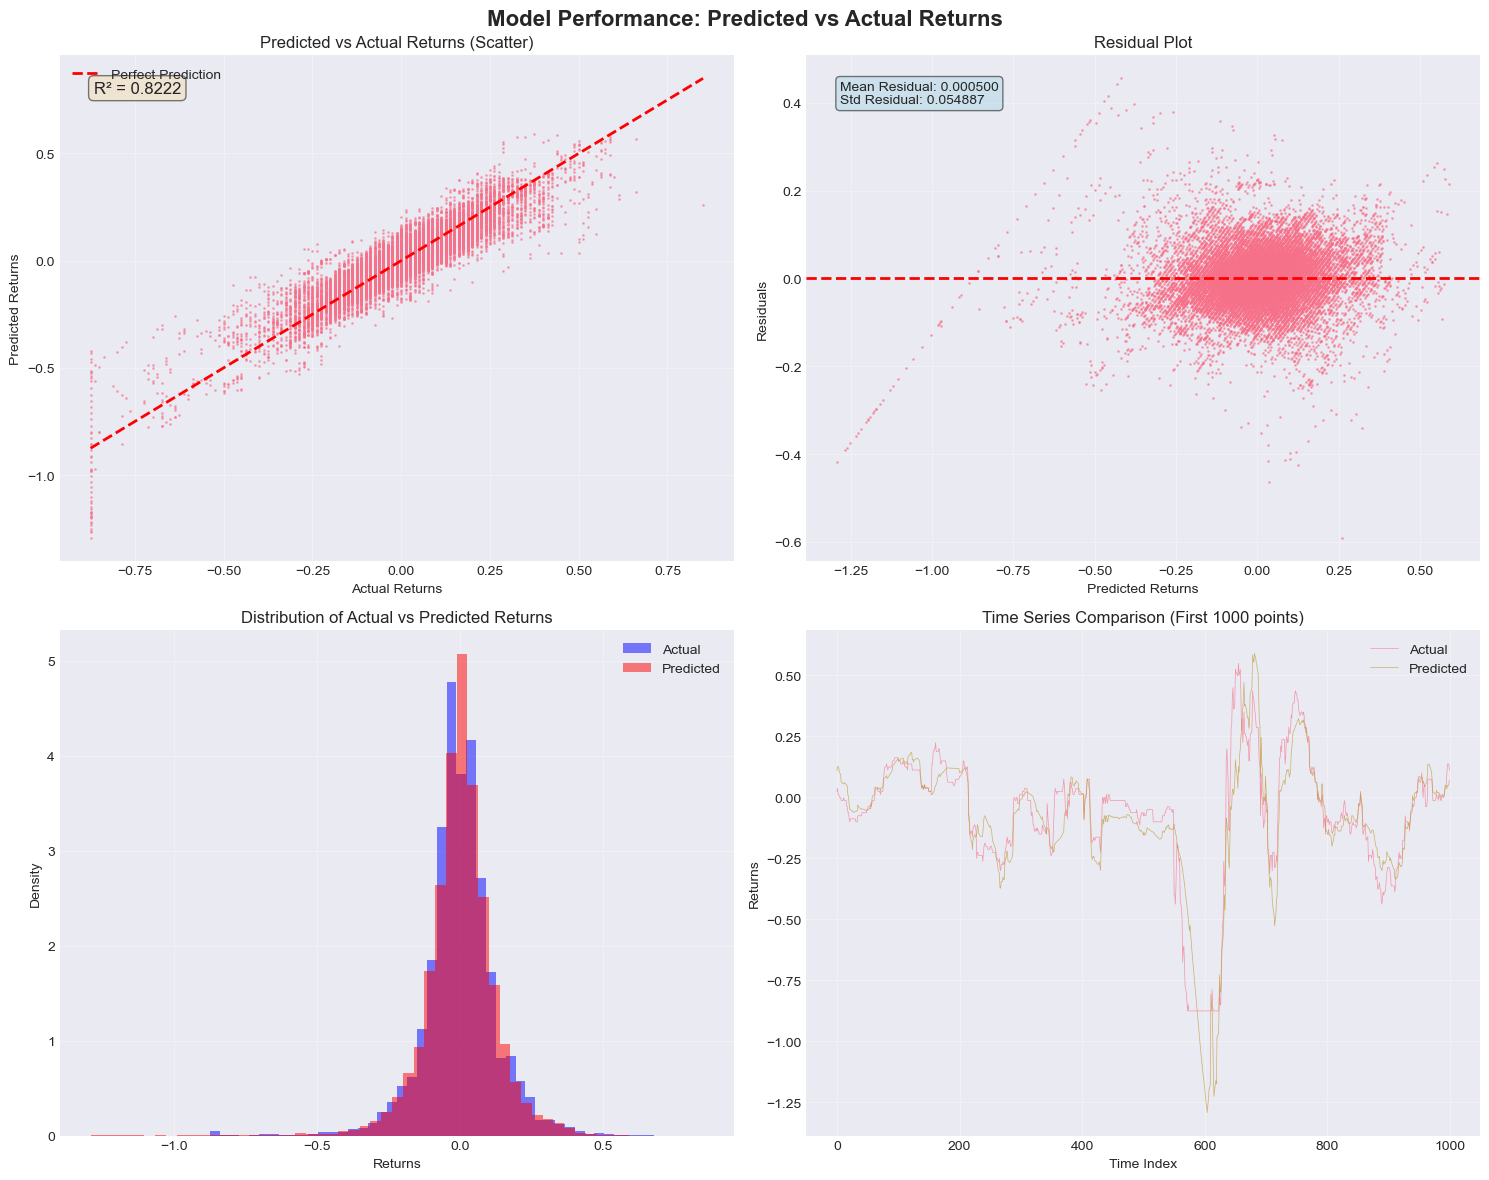


PREDICTION SUMMARY STATISTICS
Actual Returns   - Mean: 0.001222, Std: 0.129032
Predicted Returns - Mean: 0.001722, Std: 0.124285
Residuals        - Mean: 0.000500, Std: 0.054887
Correlation between actual and predicted: 0.9068

PERCENTILE ANALYSIS
10th percentile - Actual: -0.137500, Predicted: -0.128715, Diff: 0.008785
25th percentile - Actual: -0.062500, Predicted: -0.055872, Diff: 0.006628
50th percentile - Actual: 0.000000, Predicted: 0.003566, Diff: 0.003566
75th percentile - Actual: 0.062500, Predicted: 0.063449, Diff: 0.000949
90th percentile - Actual: 0.137500, Predicted: 0.135095, Diff: -0.002405


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from copy import copy
import scipy
import pickle

# %% Configuration
# Configuration parameters
droprows = 7050
std_reg_const = 0.1
normalization_std_reg = 0.0001
ridge_alpha = 1333

selected_cols = [
    # Time-based features
    'is_end_of_week',
    'weekday',
    
    # Opening/Closing difference features
    'xdiff_from_closing',
    'xdiff_from_opening',
    'ydiff_from_closing',
    
    # X-price features
    'xlog',
    'xlog_dayly_ewma_10min',
    'xprice_dayly_ewma_4hour',
    'xprice_lag_4hours',
    'xprice_time_mean_4hours',
    'xprice_time_mean_1hour_lag_4hours',
    'xprice_time_mean_1min',
    'xprice_time_mean_10min_dayly_ewma_10min',
    'xprice_time_mean_1min_rsi_1min',
    
    # Y-price features
    'ylog_dayly_ewma_1hour',
    'yprice_dayly_ewma_10min',
    'yprice_lag_4hours',
    'yprice_ewma_difpair_10min_4hour',
    'yprice_expanding_mean_diff', # FIXED: renamed from yprice_full_history_diff
    'yprice_time_mean_1hour',
    'yprice_time_mean_1hour_lag_4hours',
    'yprice_time_mean_1hour_lag_1workweek',
    'yprice_time_mean_10min',
    'yprice_time_mean_10min_dayly_ewma_4hour',
    'yprice_time_mean_10min_lag_10min',
    'yprice_time_mean_10min_rsi_1hour',
    'yprice_time_mean_2hours',
    'yprice_time_zscore_1hour',
    'yprice_time_zscore_2hours',
    
    # XY combined features
    'xy_garmonic_ewma_prodpair_2hours_1hour',
    'xy_garmonic_time_std_4hours',
    'xy_geom_time_mean_1hour_lag_20min',
    'xy_geom_time_mean_1min',
    'xy_geom_time_mean_10min_dayly_ewma_1min',
    'xy_geom_time_mean_2hours_dayly_ewma_20min',
    'xy_relation_time_std_1hour',
    'xy_relation_time_std_2hours',
    'xy_square_time_zscore_10min',
    
    # YX spread features
    'yx_spread_ewma_prodpair_1hour_10min',
    'yx_spread_time_mean_10min_lag_1hour',
    'yx_spread_time_mean_2hours_lag_20min',
    'yx_spread_time_zscore_4hours',
]


# %% Helper Functions
def print_importances(model, selected_cols):
    """Print feature importances sorted by absolute weight"""
    weigts_sum = sum(map(abs, model.coef_))
    for name, weight in sorted(zip(selected_cols, model.coef_), key=lambda x: -abs(x[1])):
        percent_weight = abs(weight) / weigts_sum
        print('{:40} {:.2%} {:15.2}'.format(name, percent_weight, weight))

def rsquared(x, y):
    """Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

def rsiFunc(prices, n=14):
    """Calculate RSI (Relative Strength Index)"""
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1]
        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)
    return rsi

# %% Time Series Validation Functions
def time_split(data, valid_ratio, test_ratio):
    """Split time series data into train, validation, and test sets"""
    n_valid = max(1, int(data.shape[0] * valid_ratio))
    n_test = max(1, int(data.shape[0] * test_ratio))
    n_train = data.shape[0] - n_valid - n_test
    
    train = data.iloc[:n_train].reset_index(drop=True).copy()
    valid = data.iloc[n_train:-n_test].reset_index(drop=True).copy()
    test = data.iloc[-n_test:].reset_index(drop=True).copy()
    merged_test = pd.concat([valid, test], ignore_index=True)
    return train, valid, test

def validate_model_by_pentate(model, source_data, base_cols, droprows=0):
    """Validate model using 5-fold time series cross-validation"""
    df = source_data.copy()
    selected_cols = base_cols.copy()
    helper_cols = list(set(selected_cols + ['periods_before_closing', 'returns']))
    metrics_dict = {}
    
    for step in range(5, 10):
        n_train = int(df.shape[0] * step // 10)
        n_test = int(df.shape[0] * (step + 1) // 10)
        train = df.iloc[:n_train].reset_index(drop=True).copy()
        test = df.iloc[n_train:n_test].reset_index(drop=True).copy()
        train.drop(np.arange(droprows), inplace=True)
        train.dropna(inplace=True)

        model.fit(train[selected_cols], train.returns)
        predicted = model.predict(test[selected_cols])
        predicted[test.periods_before_closing == 0] = 0

        current_mse = mean_squared_error(test.returns, predicted)
        current_r2 = rsquared(test.returns, predicted) * 100
        metrics_dict['train_{}_percent'.format(step * 10)] = {
            'mse': current_mse,
            'r2': current_r2
        }
    
    report = pd.DataFrame(metrics_dict)
    report['min_stats'] = report.iloc[:,:5].min(1).astype(np.float32)
    report['max_stats'] = report.iloc[:,:5].max(1).astype(np.float32)
    report['avg'] = report.mean(1).astype(np.float32)
    return report

# %% FIXED Feature Engineering Function
def create_all_features(data):
    """
    FIXED: Feature engineering without data leakage.
    All features only use data available up to time t to predict returns at time t.
    """
    print("Creating all features (FIXED - no data leakage)...")
    
    # Pre-calculate commonly used values
    days = data.day.unique()
    
    # Opening/Closing differences
    print("Creating opening/closing difference features...")
    close_price_per_day_y = data.groupby('day').timestamp.max().shift(1).map(
        data[['timestamp', 'yprice']].set_index('timestamp').yprice)
    data['ydiff_from_closing'] = (data.yprice - data.day.map(close_price_per_day_y)).fillna(0)
    
    close_price_per_day_x = data.groupby('day').timestamp.max().shift(1).map(
        data[['timestamp', 'xprice']].set_index('timestamp').xprice)
    data['xdiff_from_closing'] = (data.xprice - data.day.map(close_price_per_day_x)).fillna(0)
    
    open_price_per_day_x = data.groupby('day').timestamp.min().map(
        data[['timestamp', 'xprice']].set_index('timestamp').xprice)
    data['xdiff_from_opening'] = data.xprice - data.day.map(open_price_per_day_x)
    
    # Log features
    print("Creating log features...")
    data['xlog'] = data.xprice.apply(np.log1p)
    data['ylog'] = data.yprice.apply(np.log1p)
    
    # FIXED: Expanding mean that only uses past data
    print("Creating expanding mean difference (FIXED)...")
    data['yprice_expanding_mean_diff'] = data['yprice'] - data['yprice'].expanding(min_periods=1).mean()
    
    # FIXED: Time-based rolling features with backward-looking windows
    print("Creating time-based rolling features (FIXED)...")
    time_windows = {
        6: '1min', 60: '10min', 360: '1hour', 720: '2hours', 1410: '4hours', 2820: '1workweek'
    }
    
    # FIXED: Create all rolling means with backward-looking windows
    for window, name in time_windows.items():
        if window in [6, 60, 360, 1410]:  # xprice windows
            period_repr = '{}s'.format(window * 10)
            # FIXED: Use label='left' and closed='left' for backward-looking windows
            agg_helper_df = data['xprice'].resample(
                period_repr, label='left', closed='left').agg('mean')
            # Aggregate with multiple offsets to get more granular averages
            for shift in range(10, window * 10, 10):
                shifted_df = data['xprice'].resample(
                    period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
                agg_helper_df = pd.concat([agg_helper_df, shifted_df])
            colname = f'xprice_time_mean_{name}'
            # Forward fill to propagate past values forward
            agg_helper_df = agg_helper_df.sort_index()
            data[colname] = agg_helper_df.reindex(data.index).ffill()
            data[colname] = data['xprice'] - data[colname]
        
        if window in [60, 360, 720]:  # yprice windows
            period_repr = '{}s'.format(window * 10)
            # FIXED: Use label='left' and closed='left' for backward-looking windows
            agg_helper_df = data['yprice'].resample(
                period_repr, label='left', closed='left').agg('mean')
            for shift in range(10, window * 10, 10):
                shifted_df = data['yprice'].resample(
                    period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
                agg_helper_df = pd.concat([agg_helper_df, shifted_df])
            colname = f'yprice_time_mean_{name}'
            agg_helper_df = agg_helper_df.sort_index()
            data[colname] = agg_helper_df.reindex(data.index).ffill()
            data[colname] = data['yprice'] - data[colname]
    
    # FIXED: Create rolling std for yprice with backward-looking windows
    for window in [360, 720]:
        name = time_windows[window]
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['yprice'].resample(
            period_repr, label='left', closed='left').agg('std')
        for shift in range(10, window * 10, 10):
            shifted_df = data['yprice'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('std')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'yprice_time_std_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    
    # Z-scores for yprice
    data['yprice_time_zscore_1hour'] = data.yprice_time_mean_1hour / data.yprice_time_std_1hour
    data['yprice_time_zscore_2hours'] = data.yprice_time_mean_2hours / data.yprice_time_std_2hours
    
    # Intraday EWMA features (backward-looking by nature)
    print("Creating intraday EWMA features...")
    ewma_configs = [
        ('xprice', [24], ['4hour']),
        ('xlog', [60], ['10min']),
        ('ylog', [360], ['1hour']),
        ('yprice', [24, 60], ['4hour', '10min'])
    ]
    
    for col, windows, names in ewma_configs:
        for day in days:
            df_mask = (data.day == day)
            for window, name in zip(windows, names):
                colname = f'{col}_dayly_ewma_{name}'
                # EWMA is backward-looking by default
                ewm = pd.Series.ewm(data.loc[df_mask, col], halflife=window).mean().values
                data.loc[df_mask, colname] = ewm
                if col in ['xprice', 'yprice']:
                    data.loc[df_mask, colname] = data.loc[df_mask, col] - data.loc[df_mask, colname]
                elif col in ['xlog', 'ylog']:
                    data.loc[df_mask, colname] = data.loc[df_mask, col.replace('log', 'price')] - data.loc[df_mask, colname]
    
    # EWMA difference pair
    data['yprice_ewma_difpair_10min_4hour'] = data.yprice_dayly_ewma_10min - data.yprice_dayly_ewma_4hour
    
    # Lag features (inherently backward-looking)
    print("Creating lag features...")
    lag_configs = [
        ('xprice', 1410, '4hours'),
        ('yprice', 1410, '4hours'),
        ('xprice_time_mean_1hour', 1410, '4hours'),
        ('yprice_time_mean_1hour', 1410, '4hours'),
        ('yprice_time_mean_1hour', 2820, '1workweek'),
        ('yprice_time_mean_10min', 60, '10min')
    ]
    
    for col, lag, name in lag_configs:
        data[f'{col}_lag_{name}'] = data[col].shift(lag).values
    
    # RSI features (calculated sequentially, backward-looking)
    print("Creating RSI features...")
    data['xprice_time_mean_1min_rsi_1min'] = rsiFunc(data['xprice_time_mean_1min'].values, 6)
    data['yprice_time_mean_10min_rsi_1hour'] = rsiFunc(data['yprice_time_mean_10min'].values, 360)
    
    # Additional EWMA on time means
    print("Creating EWMA on time means...")
    ewma_on_means = [
        ('xprice_time_mean_10min', 60, '10min'),
        ('yprice_time_mean_10min', 24, '4hour')
    ]
    
    for col, window, name in ewma_on_means:
        for day in days:
            df_mask = (data.day == day)
            colname = f'{col}_dayly_ewma_{name}'
            ewm = pd.Series.ewm(data.loc[df_mask, col], halflife=window).mean().values
            data.loc[df_mask, colname] = ewm
    
    # FIXED: XY Combined features with backward-looking windows
    print("Creating XY combined features (FIXED)...")
    
    # XY Harmonic std
    agg_helper_df = data['xy_garmonic'].resample(
        '14100s', label='left', closed='left').agg('std')
    for shift in range(10, 14100, 10):
        shifted_df = data['xy_garmonic'].resample(
            '14100s', label='left', closed='left', offset='{}s'.format(shift)).agg('std')
        agg_helper_df = pd.concat([agg_helper_df, shifted_df])
    agg_helper_df = agg_helper_df.sort_index()
    data['xy_garmonic_time_std_4hours'] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    
    # Harmonic EWMA
    for day in days:
        df_mask = (data.day == day)
        data.loc[df_mask, 'xy_garmonic_dayly_ewma_1hour'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_garmonic'], halflife=360).mean().values
        data.loc[df_mask, 'xy_garmonic_dayly_ewma_2hours'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_garmonic'], halflife=720).mean().values
    
    data['xy_garmonic_dayly_ewma_1hour'] = data['xy_garmonic'] - data['xy_garmonic_dayly_ewma_1hour']
    data['xy_garmonic_dayly_ewma_2hours'] = data['xy_garmonic'] - data['xy_garmonic_dayly_ewma_2hours']
    data['xy_garmonic_ewma_prodpair_2hours_1hour'] = (
        data.xy_garmonic_dayly_ewma_2hours * data.xy_garmonic_dayly_ewma_1hour)
    
    # FIXED: XY Geometric features with backward-looking windows
    for window, name in [(6, '1min'), (60, '10min'), (360, '1hour'), (720, '2hours')]:
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['xy_geom'].resample(
            period_repr, label='left', closed='left').agg('mean')
        for shift in range(10, window * 10, 10):
            shifted_df = data['xy_geom'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'xy_geom_time_mean_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill()
        data[colname] = data['xy_geom'] - data[colname]
    
    # Geometric lags and EWMA
    data['xy_geom_time_mean_1hour_lag_20min'] = data['xy_geom_time_mean_1hour'].shift(120).values
    
    for day in days:
        df_mask = (data.day == day)
        data.loc[df_mask, 'xy_geom_time_mean_10min_dayly_ewma_1min'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_geom_time_mean_10min'], halflife=6).mean().values
        data.loc[df_mask, 'xy_geom_time_mean_2hours_dayly_ewma_20min'] = pd.Series.ewm(
            data.loc[df_mask, 'xy_geom_time_mean_2hours'], halflife=120).mean().values
    
    # FIXED: XY Relation std with backward-looking windows
    for window, name in [(360, '1hour'), (720, '2hours')]:
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['xy_relation'].resample(
            period_repr, label='left', closed='left').agg('std')
        for shift in range(10, window * 10, 10):
            shifted_df = data['xy_relation'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('std')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'xy_relation_time_std_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    
    # FIXED: XY Square zscore with backward-looking windows
    agg_helper_df_mean = data['xy_square'].resample(
        '600s', label='left', closed='left').agg('mean')
    agg_helper_df_std = data['xy_square'].resample(
        '600s', label='left', closed='left').agg('std')
    
    for shift in range(10, 600, 10):
        shifted_mean = data['xy_square'].resample(
            '600s', label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
        shifted_std = data['xy_square'].resample(
            '600s', label='left', closed='left', offset='{}s'.format(shift)).agg('std')
        agg_helper_df_mean = pd.concat([agg_helper_df_mean, shifted_mean])
        agg_helper_df_std = pd.concat([agg_helper_df_std, shifted_std])
    
    agg_helper_df_mean = agg_helper_df_mean.sort_index()
    agg_helper_df_std = agg_helper_df_std.sort_index()
    data['xy_square_time_mean_10min'] = data['xy_square'] - agg_helper_df_mean.reindex(data.index).ffill()
    data['xy_square_time_std_10min'] = agg_helper_df_std.reindex(data.index).ffill().fillna(0) + std_reg_const
    data['xy_square_time_zscore_10min'] = data['xy_square_time_mean_10min'] / data['xy_square_time_std_10min']
    
    # FIXED: YX Spread features with backward-looking windows
    print("Creating YX spread features (FIXED)...")
    for window, name in [(60, '10min'), (720, '2hours'), (1410, '4hours')]:
        period_repr = '{}s'.format(window * 10)
        agg_helper_df = data['yx_spread'].resample(
            period_repr, label='left', closed='left').agg('mean')
        for shift in range(10, window * 10, 10):
            shifted_df = data['yx_spread'].resample(
                period_repr, label='left', closed='left', offset='{}s'.format(shift)).agg('mean')
            agg_helper_df = pd.concat([agg_helper_df, shifted_df])
        colname = f'yx_spread_time_mean_{name}'
        agg_helper_df = agg_helper_df.sort_index()
        data[colname] = agg_helper_df.reindex(data.index).ffill()
        data[colname] = data['yx_spread'] - data[colname]
    
    # FIXED: Spread std and zscore with backward-looking windows
    agg_helper_df = data['yx_spread'].resample(
        '14100s', label='left', closed='left').agg('std')
    for shift in range(10, 14100, 10):
        shifted_df = data['yx_spread'].resample(
            '14100s', label='left', closed='left', offset='{}s'.format(shift)).agg('std')
        agg_helper_df = pd.concat([agg_helper_df, shifted_df])
    agg_helper_df = agg_helper_df.sort_index()
    data['yx_spread_time_std_4hours'] = agg_helper_df.reindex(data.index).ffill().fillna(0) + std_reg_const
    data['yx_spread_time_zscore_4hours'] = data['yx_spread_time_mean_4hours'] / data['yx_spread_time_std_4hours']
    
    # Spread lags (inherently backward-looking)
    data['yx_spread_time_mean_10min_lag_1hour'] = data['yx_spread_time_mean_10min'].shift(360).values
    data['yx_spread_time_mean_2hours_lag_20min'] = data['yx_spread_time_mean_2hours'].shift(120).values
    
    # Spread EWMA (backward-looking by nature)
    for day in days:
        df_mask = (data.day == day)
        data.loc[df_mask, 'yx_spread_dayly_ewma_10min'] = pd.Series.ewm(
            data.loc[df_mask, 'yx_spread'], halflife=60).mean().values
        data.loc[df_mask, 'yx_spread_dayly_ewma_1hour'] = pd.Series.ewm(
            data.loc[df_mask, 'yx_spread'], halflife=360).mean().values
    
    data['yx_spread_dayly_ewma_10min'] = data['yx_spread'] - data['yx_spread_dayly_ewma_10min']
    data['yx_spread_dayly_ewma_1hour'] = data['yx_spread'] - data['yx_spread_dayly_ewma_1hour']
    data['yx_spread_ewma_prodpair_1hour_10min'] = (
        data.yx_spread_dayly_ewma_1hour * data.yx_spread_dayly_ewma_10min)
    
    # Clean up temporary columns
    temp_cols = [
        'xy_garmonic_dayly_ewma_1hour', 'xy_garmonic_dayly_ewma_2hours',
        'xy_square_time_mean_10min', 'xy_square_time_std_10min',
        'yx_spread_dayly_ewma_10min', 'yx_spread_dayly_ewma_1hour',
        'yprice_time_std_1hour', 'yprice_time_std_2hours',
        'yx_spread_time_std_4hours'
    ]
    
    for col in temp_cols:
        if col in data.columns:
            data.drop(col, axis=1, inplace=True)
    
    print("Feature engineering completed (NO DATA LEAKAGE)!")
    return data

# %% Data Initialization and Feature Engineering
def init_data(train_fname, test_fname=None):
    """Initialize and preprocess data"""
    print('loading train file...')
    data = pd.read_csv(train_fname)
    ntrain = data.shape[0]
    if test_fname:
        print('loading test file...')
        test_data = pd.read_csv(test_fname)
        data = pd.concat([data, test_data], ignore_index=True)
    data['xprice'] -= 127  # WARNING!
    data['yprice'] -= 146  # WARNING!
    
    data['yx_spread'] = data.yprice - data.xprice
    data['yx_relation'] = data.yprice / data.xprice
    data['xy_relation'] = data.xprice / data.yprice
    data['xy_square'] = np.sqrt(data.xprice ** 2 + data.yprice ** 2) / 2
    data['xy_geom'] = np.sqrt(data.xprice * data.yprice)
    data['xy_garmonic'] = 2 / (1 / data.xprice + 1 / data.yprice)
    
    data['timestamp'] = data['timestamp'] // 1000
    data['timestamp'] = data['timestamp'].apply(lambda stamp: datetime.fromtimestamp(stamp))
    data['timestamp'] = data['timestamp'] - pd.Timedelta(hours=1)
    data.index = data['timestamp']
    
    data['weekday'] = data.timestamp.dt.weekday
    data['is_end_of_week'] = (data.timestamp.dt.weekday >= 2).astype(int)
    
    data['day'] = (data.timestamp.dt.date - data.timestamp.dt.date.min()).apply(lambda x: int(x.days))
    day_close_time = data.day.map(data.groupby('day').timestamp.max())
    data['periods_before_closing'] = (day_close_time - data.timestamp).apply(lambda x: x.seconds // 10)
    day_open_time = data.day.map(data.groupby('day').timestamp.min())
    data['periods_after_opening'] = (data.timestamp - day_open_time).apply(lambda x: x.seconds // 10)
    return data, ntrain

def selected_features_extractor(train_data_path, test_data_path=None):
    """Main feature extraction pipeline"""
    data, ntrain = init_data(train_data_path, test_data_path)
    
    # Use the FIXED feature engineering function
    data = create_all_features(data)
    
    usecols = selected_cols + ['returns', 'periods_before_closing']
    
    train = data[usecols].iloc[droprows:ntrain]
    test = data[usecols].iloc[ntrain:]
    return train, test

# %% Model Training Functions
def normalize_train(df):
    """Normalize training data"""
    extended_cols = selected_cols + ['returns', 'periods_before_closing']
    norm_train = df[extended_cols].reset_index(drop=True).copy()
    norm_mean = norm_train[selected_cols].mean()
    norm_std = norm_train[selected_cols].std() + normalization_std_reg
    norm_train.loc[:,selected_cols] = (norm_train[selected_cols] - norm_mean) / norm_std
    return norm_train

def normalize_train_test(train, test):
    """Normalize train and test data using training statistics"""
    train_extended_cols = selected_cols + ['returns', 'periods_before_closing']
    test_extended_cols = selected_cols + ['periods_before_closing']
    
    norm_train = train[train_extended_cols].reset_index(drop=True).copy()
    norm_test = test[test_extended_cols].reset_index(drop=True).copy()
    
    norm_mean = norm_train[selected_cols].mean()
    norm_std = norm_train[selected_cols].std() + normalization_std_reg
    
    norm_train.loc[:,selected_cols] = (norm_train[selected_cols] - norm_mean) / norm_std
    norm_test.loc[:,selected_cols] = (norm_test[selected_cols] - norm_mean) / norm_std
    return norm_train, norm_test


def plot_predictions(predictions, actual_returns, save_path=None):
    """
    Create comprehensive visualization of predicted vs actual returns
    
    Parameters:
    predictions: array of predicted values
    actual_returns: array of actual return values
    save_path: optional path to save the figure
    """
    # Set style for better-looking plots
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance: Predicted vs Actual Returns', fontsize=16, fontweight='bold')
    
    # 1. Scatter plot of predicted vs actual
    ax1 = axes[0, 0]
    ax1.scatter(actual_returns, predictions, alpha=0.5, s=1)
    ax1.plot([actual_returns.min(), actual_returns.max()], 
             [actual_returns.min(), actual_returns.max()], 
             'r--', lw=2, label='Perfect Prediction')
    ax1.set_xlabel('Actual Returns')
    ax1.set_ylabel('Predicted Returns')
    ax1.set_title('Predicted vs Actual Returns (Scatter)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add R-squared to the plot
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(actual_returns, predictions)
    ax1.text(0.05, 0.95, f'R² = {r_value**2:.4f}', 
             transform=ax1.transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Residual plot
    ax2 = axes[0, 1]
    residuals = predictions - actual_returns
    ax2.scatter(predictions, residuals, alpha=0.5, s=1)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicted Returns')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    ax2.grid(True, alpha=0.3)
    
    # Add residual statistics
    ax2.text(0.05, 0.95, f'Mean Residual: {np.mean(residuals):.6f}\nStd Residual: {np.std(residuals):.6f}', 
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    # 3. Distribution comparison
    ax3 = axes[1, 0]
    ax3.hist(actual_returns, bins=50, alpha=0.5, label='Actual', density=True, color='blue')
    ax3.hist(predictions, bins=50, alpha=0.5, label='Predicted', density=True, color='red')
    ax3.set_xlabel('Returns')
    ax3.set_ylabel('Density')
    ax3.set_title('Distribution of Actual vs Predicted Returns')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Time series plot (if we have enough points)
    ax4 = axes[1, 1]
    # Plot a subset for clarity (first 1000 points)
    plot_size = min(1000, len(predictions))
    indices = np.arange(plot_size)
    ax4.plot(indices, actual_returns[:plot_size], label='Actual', alpha=0.7, linewidth=0.5)
    ax4.plot(indices, predictions[:plot_size], label='Predicted', alpha=0.7, linewidth=0.5)
    ax4.set_xlabel('Time Index')
    ax4.set_ylabel('Returns')
    ax4.set_title(f'Time Series Comparison (First {plot_size} points)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    
    return fig


# %% Model Estimation Function
def modelEstimate(train_data_path):
    """
    Train the model on the training data.
    
    Parameters:
    train_data_path (str): Path to the training CSV file
    
    Returns:
    dict: Dictionary containing the trained model and normalization parameters
    """
    print('--------->Start Estimation....')
    
    # Extract features
    train, _ = selected_features_extractor(train_data_path)
    
    # Normalize training data
    print('----->Normalization....')
    norm_train = normalize_train(train)
    
    # Calculate normalization parameters for later use
    norm_mean = train[selected_cols].mean()
    norm_std = train[selected_cols].std() + normalization_std_reg
    
    # Validate model
    print('----->Validation....')
    model = Ridge(alpha=ridge_alpha)
    print(validate_model_by_pentate(model, norm_train, selected_cols, 0))
    
    # Fit final model
    print('----->Fitting....')
    model = Ridge(alpha=ridge_alpha)
    model.fit(norm_train[selected_cols], norm_train.returns)
    
    # Print feature importances
    print('----->Calculation feature importances...')
    print_importances(model, selected_cols)
    
    # Return model and parameters
    return {
        'model': model,
        'norm_mean': norm_mean,
        'norm_std': norm_std
    }

# %% Model Forecast Function
def modelForecast(test_data_path, model_params, train_data_path):
    """
    Make predictions on test data using the trained model.
    
    Parameters:
    test_data_path (str): Path to the test CSV file
    model_params (dict): Dictionary containing the trained model and normalization parameters
    train_data_path (str): Path to the training CSV file (needed for feature extraction)
    
    Returns:
    dict: Dictionary containing predictions and evaluation metrics (if test data has returns)
    """
    print('--------->Starting Forecasting....')
    
    # Extract features for both train and test
    train, test = selected_features_extractor(train_data_path, test_data_path)
    
    # Normalize test data using training statistics
    print('----->Normalization....')
    test_extended_cols = selected_cols + ['periods_before_closing']
    
    # Check if test data has returns column for evaluation
    has_returns = 'returns' in test.columns
    if has_returns:
        test_extended_cols.append('returns')
    
    norm_test = test[test_extended_cols].reset_index(drop=True).copy()
    norm_test.loc[:,selected_cols] = (norm_test[selected_cols] - model_params['norm_mean']) / model_params['norm_std']
    
    # Make predictions
    print('----->Prediction....')
    predicted = model_params['model'].predict(norm_test[selected_cols])
    
    # Set predictions to 0 at closing periods
    predicted[norm_test.periods_before_closing == 0] = 0
    
    # Calculate evaluation metrics if test data has returns
    results = {'predictions': predicted}
    
    if has_returns:
        print('----->Evaluation....')
        # Calculate MSE
        mse = mean_squared_error(norm_test.returns, predicted)
        # Calculate R-squared
        r2 = rsquared(norm_test.returns, predicted)
        
        results['mse'] = mse
        results['r2'] = r2
        
        print(f'Test MSE: {mse:.6f}')
        print(f'Test R-squared: {r2:.6f}')
        print(f'Test R-squared (x100): {r2*100:.2f}')
    else:
        print('No returns column in test data - evaluation metrics not calculated')
    
    return results

# Main execution block with plotting
if __name__ == "__main__":
    # Train the model
    train_file_path = '/Users/mazin/Desktop/super prep materials/GSAPred/Two-financial-instruments/train.csv'
    model_params = modelEstimate(train_file_path)
    
    # Make predictions
    test_file_path = '/Users/mazin/Desktop/super prep materials/GSAPred/Two-financial-instruments/test.csv'
    results = modelForecast(test_file_path, model_params, train_file_path)
    
    # Extract predictions
    predictions = results['predictions']
    
    # Display results
    print(f"\nFirst 10 predictions: {predictions[:10]}")
    print(f"Total predictions: {len(predictions)}")
    
    # Display evaluation metrics if available
    if 'mse' in results:
        print(f"\nEvaluation Metrics:")
        print(f"MSE: {results['mse']:.6f}")
        print(f"R-squared: {results['r2']:.6f}")
        print(f"R-squared (x100): {results['r2']*100:.2f}")
    
    # ============== PLOTTING SECTION ==============
    print("\n" + "="*50)
    print("Generating visualizations...")
    print("="*50)
    
    # Load test data to check if it has returns and get actual values
    train, test = selected_features_extractor(train_file_path, test_file_path)
    
    # Plot predictions vs actual if test data has returns
    if 'returns' in test.columns:
        actual_returns = test['returns'].values
        
        # Create prediction vs actual plots
        fig = plot_predictions(predictions, actual_returns, save_path='predictions_analysis.png')
        
        # Print numerical summary
        print("\n" + "="*50)
        print("PREDICTION SUMMARY STATISTICS")
        print("="*50)
        print(f"Actual Returns   - Mean: {np.mean(actual_returns):.6f}, Std: {np.std(actual_returns):.6f}")
        print(f"Predicted Returns - Mean: {np.mean(predictions):.6f}, Std: {np.std(predictions):.6f}")
        print(f"Residuals        - Mean: {np.mean(predictions - actual_returns):.6f}, Std: {np.std(predictions - actual_returns):.6f}")
        
        # Correlation analysis
        correlation = np.corrcoef(actual_returns, predictions)[0, 1]
        print(f"Correlation between actual and predicted: {correlation:.4f}")
        
        # Calculate percentile-based metrics
        print("\n" + "="*50)
        print("PERCENTILE ANALYSIS")
        print("="*50)
        percentiles = [10, 25, 50, 75, 90]
        for p in percentiles:
            actual_p = np.percentile(actual_returns, p)
            pred_p = np.percentile(predictions, p)
            print(f"{p}th percentile - Actual: {actual_p:.6f}, Predicted: {pred_p:.6f}, Diff: {pred_p - actual_p:.6f}")
    else:
        print("Test data does not contain 'returns' column - cannot create comparison plots")
        print("Predictions have been generated and stored in 'predictions' variable")